# Тренировка нейронных сетей на реальных данных

## Классификация котов и собак

Мы построим небольшую нейросеть, способную с хорошей точностью отличить изображение кошки от изображения собаки

#### Google Colab

In [ ]:
# Запускать только если вы работаете в google collab

from google.colab import drive
drive.mount('/content/drive')

# План занятия

* Загрузка и подготовка датасета
* Написания алгоритма тренировки сети
* Создание архитектуры и эксперименты

Импортируем все нужные библиотеки и функции

In [ ]:
import os

from matplotlib import pyplot as plt
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchsummary import summary

Определим в одном месте все константы, которые понадобятся нам в дальнейшем. Их смысл будет прояснён по мере использования

In [ ]:
### Let's have a cell with global hyperparameters for the CNNs in this notebook

# Path to a directory with image dataset and subfolders for training, validation and final testing
DATA_PATH = 'data' # PATH TO THE DATASET

# Number of threads for data loader
NUM_WORKERS = 4

# Image size: even though image sizes are bigger than 96, we use this to speed up training
SIZE_H = SIZE_W = 96
N_CHANNELS = 3

# Number of classes in the dataset
NUM_CLASSES = 2

# Epochs: number of passes over the training data, we use it this small to reduce training babysitting time
EPOCH_NUM = 30

# Batch size: for batch gradient descent optimization, usually selected as 2**K elements
BATCH_SIZE = 128

# Images mean and std channelwise
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

# Last layer (embeddings) size for CNN models
EMBEDDING_SIZE = 256

In [ ]:
# используем GPU при наличии
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Подготовка датасета

## Датасеты в pytorch

Для того, чтобы обучать модели, нам первым делом нужно загрузить данные в память. Обычно для этого используются специальные библиотеки:
* для картинок `pillow`, `opencv`
* для аудио `scipy`, `librosa`
* для текстов `nltk`

После загрузки данных их нужно перевести в формат `torch.Tensor`, сделать предобработку.

В таком виде они подаются в модель.

### Загрузка данных

Сегодня мы будем решать упрощённую версию известного соревнования [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats)

По ссылке ниже содержится уменьшенный в целях экономии времени обучения датасет

In [ ]:
!wget -nc https://www.dropbox.com/s/gqdo90vhli893e0/data.zip
!unzip -n data.zip -d data

'wget' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


Загруженные нами данные имеют стандартную структуру: картинки каждого класса лежат в своей папке.

```
DATA_PATH/dog/xxx.png
DATA_PATH/dog/xxy.png
DATA_PATH/dog/xxz.png
... # другие изображения собак

DATA_PATH/cat/123.png
DATA_PATH/cat/nsdf3.png
DATA_PATH/cat/asd932_.png
... # другие изображения кошек
```

В pytorch имеется специальный загрузчик для такой структуры - `ImageFolder`

После загрузки он может по индексу отдавать картинку вместе со своей меткой

Также для создания датасета нам потребуется определить набор преобразований над загруженной картинкой.

1. Все изображения имеют разные начальные размеры в то время как нейросеть принимает на вход массивы одинаковой формы. Поэтому мы будем сжимать изображение до одинакового размера (в нашем случае `96x96`)
2. Преобразуем данные в `torch.Tensor` чтобы нейросеть могла с ними работать (изначально данные загружаются в `numpy`)
3. Нормализуем выборку (вычитаем среднее и делим на стандартное отклонение каждый из 3 каналов изображния)

In [ ]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),        # scaling images to fixed size
    transforms.ToTensor(),                      # converting to tensors
    transforms.Normalize(image_mean, image_std) # normalize image data per-channel
])

Наконец, создаём датасеты для тренировки, валидации и тестирования

In [ ]:
train_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train_11k'), transform=transformer)
val_dataset   = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'val'), transform=transformer)
test_dataset  = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test_labeled'), transform=transformer)

Также для удобства запомним размеры датасетов

In [ ]:
n_train, n_val, n_test = len(train_dataset), len(val_dataset), len(test_dataset)

В реальных задачах размеры датасетов могут доходить до десятков терабайт, поэтому их невозможно хранить в оперативной памяти одновременно ( а значит и одновременно обучать нейросеть по всей выборке). Поэтому нам потребуются вспомогательные объекты - `DataLoader`ы

Они делят датасет на части одинакового заранее заданного размера (в нашем случае 128 картинок) и выдают эти части последовательно для проведения обучения на них. Такие части называются батчами (batch)

In [ ]:
def worker_init_fn(worker_id):                                                          
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    #worker_init_fn=worker_init_fn
)

In [ ]:
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    #worker_init_fn=worker_init_fn
)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    #worker_init_fn=worker_init_fn
)

Также мы напишем функцию для удобной визуализации картинок

In [ ]:
def plot_from_loader(loader):
    data_batch, label_batch = next(iter(loader))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    class_names = loader.dataset.classes
    for i in range(grid_size[0] * grid_size[1]):
        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])
        
        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)
        
        # display batch samples with labels
        sample_title = 'Label = %d (%s)' % (label_batch[i], class_names[label_batch[i]])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)

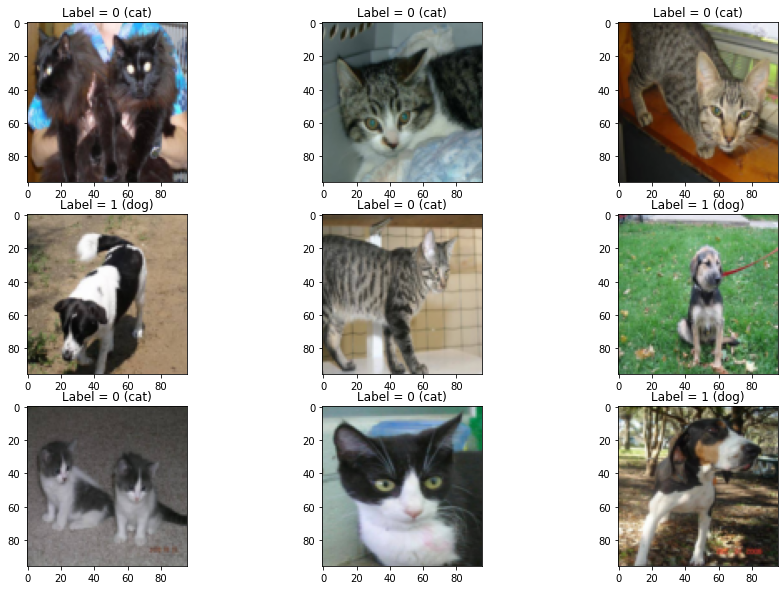

In [ ]:
# при каждом запуске мы увидим разные картинки т.к. DataLoader выдаёт случайные подмножества датасета
plot_from_loader(train_loader)

# Тренировка нейросети

Ниже мы реализуем алгоритм тренировки сети (training loop)

Функция тренировки (`train_model`) верхнеуровнево состоит из т.н. эпох (полных проходов датасета) включающих в себя обучение на тренировочных данных и проверке качества на валидационных данных.

Далее нам понадобится функция проверки качества на отложенной (тестовой) выборке без обучения (`test_model`)

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [ ]:
def test_model(model, test_loader, subset='test'):
    model.train(False) # disable dropout / use averages for batch_norm
    test_batch_acc = []
    for X_batch, y_batch in test_loader:
        logits = model(X_batch.to(device))
        y_pred = logits.max(1)[1].data
        test_batch_acc.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

    test_accuracy = np.mean(test_batch_acc)
    
    print("Results:")
    print(f"  {subset} accuracy:\t\t{test_accuracy * 100:.2f} %")
    if test_accuracy > 0.9:
        print("Amazing!")
    elif test_accuracy > 0.7:
        print("Good!")
    else:
        print("We need more magic! Follow instructons below")
    return test_accuracy

# Создание полносвязной сети

Мы сконструируем простую нейросеть из полносвязных слоёв и натренируем её на имеющемся датасете.

В общем случае для картинок лучше подходят свёрточные сети (их тоже не сложно создать и обучить теми же инструментами)

Для того, чтобы полносвязная сеть могла обработать картинку, нам нужно ещё превратить в одномерный вектор.

Для этого мы напишем "слой" превращающий данные в "плоские" вместо квадраных

In [ ]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

Наша модель - последовательное применение модулей нейросети.

Для удобной упаковки последовательных модулей используется класс `Sequential`

In [ ]:
model = nn.Sequential(
    # сперва выпрямляем картинку в вектор
    Flatten(),

    # далее создаём сеть с несколькими слоями
    nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256),
    nn.ReLU(),
    nn.Dropout(0.05),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Dropout(0.05),

    # заканичваем сеть слоем имеющим размерность количества классов - это будут вероятности каждого класса
    nn.Linear(128, NUM_CLASSES),
    nn.Sigmoid(),
)

model = model.to(device)

Выведем краткое описание модели и информацию о её производительности

In [ ]:
summary(model, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
           Sigmoid-9                    [-1, 2]               0
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
-------------------------------------

### Запускаем тренировку

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

loss_fn = nn.CrossEntropyLoss()

train_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_fn, opt, 5)

Epoch 1 of 5 took 29.710s
  training loss (in-iteration): 	0.658290
  validation accuracy: 			57.57 %
Epoch 2 of 5 took 29.443s
  training loss (in-iteration): 	0.619517
  validation accuracy: 			58.06 %
Epoch 3 of 5 took 28.860s
  training loss (in-iteration): 	0.592601
  validation accuracy: 			61.45 %
Epoch 4 of 5 took 29.312s
  training loss (in-iteration): 	0.567205
  validation accuracy: 			60.22 %
Epoch 5 of 5 took 30.170s
  training loss (in-iteration): 	0.550481
  validation accuracy: 			62.52 %


In [ ]:
# созраним модель, если она показала себя хорошо
best_model = model

Поэкспериментируете с кол-вом эпох и архитектурой сети. Обычно нужно не более 15 эпох.

### Проверим точность предсказаний на отложенной выборке

In [ ]:
val_acc = test_model(model, val_loader, 'val')
test_acc = test_model(model, test_loader, 'test')

Results:
  val accuracy:		58.50 %
We need more magic! Follow instructons below
Results:
  test accuracy:		61.26 %
We need more magic! Follow instructons below


In [ ]:
class VisualNet(torch.nn.Module):
  # инициализация объекта класса
  def __init__(self):
    # сначала запустим init аналогичный родительскому классу
    super(VisualNet, self).__init__() 
    self.flatten = Flatten()
    self.linear1 = nn.Linear(N_CHANNELS * SIZE_H * SIZE_W, 256)
    torch.nn.init.xavier_uniform_(self.linear1.weight, 0.0)
    self.relu1 = nn.ReLU()
    self.dropout1 = nn.Dropout(0.3)
    self.linear2 = nn.Linear(256, 128)
    torch.nn.init.xavier_uniform_(self.linear2.weight, 0.0)
    self.relu2 = nn.ReLU()
    self.dropout2 = nn.Dropout(0.3)
    self.linear3 = torch.nn.Linear(128, NUM_CLASSES)
    torch.nn.init.xavier_uniform_(self.linear3.weight, 0.0)
    self.classify = nn.Sigmoid()

  # подсчет прогноза
  def forward(self, x):
    out = self.flatten(x)
    out = self.relu1(self.linear1(out))
    out = self.dropout1(out)
    out = self.relu2(self.linear2(out))
    out = self.dropout2(out)
    out = self.linear3(out)
    out = self.classify(out)
    return out

In [ ]:
model = VisualNet()
model = model.to(device)

In [ ]:
summary(model, (N_CHANNELS, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 27648]               0
            Linear-2                  [-1, 256]       7,078,144
              ReLU-3                  [-1, 256]               0
           Dropout-4                  [-1, 256]               0
            Linear-5                  [-1, 128]          32,896
              ReLU-6                  [-1, 128]               0
           Dropout-7                  [-1, 128]               0
            Linear-8                    [-1, 2]             258
           Sigmoid-9                    [-1, 2]               0
Total params: 7,111,298
Trainable params: 7,111,298
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.11
Forward/backward pass size (MB): 0.22
Params size (MB): 27.13
Estimated Total Size (MB): 27.45
-------------------------------------

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()

train_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_fn, opt, 5)

Epoch 1 of 5 took 37.457s
  training loss (in-iteration): 	0.668875
  validation accuracy: 			58.04 %
Epoch 2 of 5 took 29.665s
  training loss (in-iteration): 	0.630368
  validation accuracy: 			60.48 %
Epoch 3 of 5 took 32.875s
  training loss (in-iteration): 	0.605963
  validation accuracy: 			62.01 %
Epoch 4 of 5 took 31.770s
  training loss (in-iteration): 	0.589651
  validation accuracy: 			61.45 %
Epoch 5 of 5 took 31.708s
  training loss (in-iteration): 	0.575717
  validation accuracy: 			61.15 %


In [ ]:
clip_value = 5

In [ ]:
model = VisualNet()
model = model.to(device)

In [ ]:
for p in model.parameters():
    p.register_hook(lambda grad: torch.clamp(grad, -clip_value, clip_value))

In [ ]:
def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs):
    '''
    model: нейросеть для обучения,
    train_loader, val_loader: загрузчики данных
    loss_fn: целевая метрика (которую будем оптимизировать)
    opt: оптимизатор (обновляет веса нейросети)
    n_epochs: кол-во эпох, полных проходов датасета
    '''
    train_loss = []
    val_accuracy = []
    
    for epoch in range(n_epochs):
        start_time = time.time()

        model.train(True) # enable dropout / batch_norm training behavior
        for X_batch, y_batch in train_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # train on batch: compute loss, calc grads, perform optimizer step and zero the grads
            opt.zero_grad()
            predictions = model(X_batch)
            loss = loss_fn(predictions, y_batch)
            loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
            opt.step()
            train_loss.append(loss.item())

        model.train(False) # disable dropout / use averages for batch_norm
        for X_batch, y_batch in val_loader:
            # move data to target device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # compute logits
            logits = model(X_batch)
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean( (y_batch.cpu() == y_pred.cpu()).numpy() ))

        # print the results for this epoch:
        print(f'Epoch {epoch + 1} of {n_epochs} took {time.time() - start_time:.3f}s')

        train_loss_value = np.mean(train_loss[-n_train // BATCH_SIZE :])
        val_accuracy_value = np.mean(val_accuracy[-n_val // BATCH_SIZE :]) * 100
        
        print(f"  training loss (in-iteration): \t{train_loss_value:.6f}")
        print(f"  validation accuracy: \t\t\t{val_accuracy_value:.2f} %")

    return train_loss, val_accuracy

In [ ]:
opt = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)

loss_fn = nn.CrossEntropyLoss()

train_loss, val_accuracy = train_model(model, train_loader, val_loader, loss_fn, opt, 5)

Epoch 1 of 5 took 33.541s
  training loss (in-iteration): 	0.678167
  validation accuracy: 			57.24 %
Epoch 2 of 5 took 31.763s
  training loss (in-iteration): 	0.644080
  validation accuracy: 			59.27 %
Epoch 3 of 5 took 33.276s
  training loss (in-iteration): 	0.613139
  validation accuracy: 			61.18 %
Epoch 4 of 5 took 28.893s
  training loss (in-iteration): 	0.594081
  validation accuracy: 			62.38 %
Epoch 5 of 5 took 28.537s
  training loss (in-iteration): 	0.583324
  validation accuracy: 			62.77 %


In [ ]:
optimizer.zero_grad()        
loss, hidden = model(data, hidden, targets)
loss.backward()

torch.nn.utils.clip_grad_norm_(model.parameters(), args.clip)
optimizer.step()

In [ ]:
conv1 = torch.nn.Conv2d(...)
torch.nn.init.xavier_uniform_(conv1.weight)

# Бонусная часть: свёртки

### First step

**conv-pool-conv-pool-dense-dense-everybody!**

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3 classic convolutional blocks `convolution->relu->pool`: 
  * 3x3 convolution with 128 filters and _ReLU_ activation
  * 2x2 pooling (or set previous convolution stride to 3)
 * Flatten
* 30% Dropout 
* Dense layer with 256 neurons and _ReLU_ activation
* 30% dropout
* Output dense layer.

__Convolutional layers__ in torch are just like all other layers, but with a specific set of parameters:

__`...`__

__`model.add_module('conv1', nn.Conv2d(in_channels=3, out_channels=128, kernel_size=3)) # convolution`__

__`model.add_module('pool1', nn.MaxPool2d(2)) # max pooling 2x2`__

__`...`__


Once you're done (and compute_loss no longer raises errors), train it with __Adam__ optimizer with learning_rate=3e-4 (Karpathy Constant)

If everything is right, you should get at least __75%__ validation accuracy.

__HACK_OF_THE_DAY__ :the number of channels must be in the order of the number of class_labels

__HACK_OF_THE_DAY_2__ : you may set stride=2 for Conv2d layers to increase learning speed, but keep in mind tensor shapes

In [ ]:
model_cnn = nn.Sequential()

# Your code here: CONV->POOL->CONV-POOL->... as many as you wish

# End of your code here
# global average pooling
model_cnn.add_module('gap_5', nn.AvgPool2d(20))
# dropout for regularization
model_cnn.add_module('dropout_5', nn.Dropout(0.3))
# "flatten" the data
model_cnn.add_module('flat', Flatten())
# last fully-connected layer, used to create embedding vectors
model_cnn.add_module('fc_6', nn.Linear(128, EMBEDDING_SIZE))
model_cnn.add_module('relu_6', nn.ReLU())

model_cnn.add_module('dropout_6', nn.Dropout(0.3))

# logits for NUM_CLASSES=2 classes
model_cnn.add_module('fc_logits', nn.Linear(EMBEDDING_SIZE, NUM_CLASSES))
model_cnn.add_module('fc_preds', nn.Sigmoid())

# move model to computing device
model_cnn = model_cnn.to(device)

In [ ]:
??nn.Linear

In [ ]:
torch.nn.parameter.Parameter(torch.Tensor(10, 10))

Parameter containing:
tensor([[-3.5073e-31,  4.0217e-43, -3.5080e-31,  4.0217e-43, -3.5078e-31,
          4.0217e-43, -1.5529e-23,  4.0217e-43, -1.5529e-23,  4.0217e-43],
        [-1.5530e-23,  4.0217e-43, -1.5530e-23,  4.0217e-43, -1.5530e-23,
          4.0217e-43, -1.5530e-23,  4.0217e-43, -1.5530e-23,  4.0217e-43],
        [-1.5530e-23,  4.0217e-43, -1.5530e-23,  4.0217e-43, -1.5531e-23,
          4.0217e-43, -1.5531e-23,  4.0217e-43, -1.5531e-23,  4.0217e-43],
        [-1.5531e-23,  4.0217e-43, -1.5531e-23,  4.0217e-43, -1.5531e-23,
          4.0217e-43, -1.5531e-23,  4.0217e-43, -1.5532e-23,  4.0217e-43],
        [-1.5532e-23,  4.0217e-43, -1.5532e-23,  4.0217e-43, -1.5532e-23,
          4.0217e-43, -1.5532e-23,  4.0217e-43, -1.5532e-23,  4.0217e-43],
        [-1.5533e-23,  4.0217e-43, -1.5533e-23,  4.0217e-43, -1.5533e-23,
          4.0217e-43, -1.5533e-23,  4.0217e-43, -1.5533e-23,  4.0217e-43],
        [-1.5533e-23,  4.0217e-43, -1.5533e-23,  4.0217e-43, -1.5534e-23,
          


__Hint:__ If you don't want to compute shapes by hand, just plug in any shape (e.g. 1 unit) and run compute_loss. You will see something like this:

__`RuntimeError: size mismatch, m1: [5 x 1960], m2: [1 x 64] at /some/long/path/to/torch/operation`__

See the __1960__ there? That's your actual input shape.

Let's see the basic structure of our model and at the same time perform a sanity check for tensor dimensions.

In [ ]:
summary(model_cnn, (3, SIZE_H, SIZE_W))

RuntimeError: mat1 dim 1 must match mat2 dim 0

#### Training

In [ ]:
opt = torch.optim.Adam(model_cnn.parameters(), lr=3e-4)
opt.zero_grad()
ckpt_name_cnn='model_cnn.ckpt'
model_cnn, opt, losses_cnn = train_model(model_cnn,
                                                 train_loader,
                                                 val_loader,
                                                 opt)

TypeError: train_model() missing 2 required positional arguments: 'opt' and 'n_epochs'

**A kind reminder again:** don't wait for too many  epochs. You can interrupt training after 5-20 epochs once validation accuracy stops going up.
```
```
#### Evaluation 


In [ ]:
best_model_cnn = None
with open(ckpt_name_cnn, 'rb') as f:
    best_model_cnn = torch.load(f)

val_accuracy = test_model(best_model_cnn, val_loader, subset='val')
test_accuracy = test_model(best_model_cnn, test_loader, subset='test')